In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [ ]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
    mdpKernelParams = pickle.load(f)
mdpPolicyOne = MdpKernel()
mdpPolicyOne.load_policy(mdpKernelParams, policyMode="deterministic", randomR=False)
mdpPolicyTwo = MdpKernel()
mdpPolicyTwo.load_policy(mdpKernelParams, policyMode="stochastic", randomR=False)

# ==== Prepare Simulator====
num_windows = 20000
obvMode = "predicted" # "perfect" or "predicted"

policySimulator = PolicySimulator(mdpPolicyOne, env)
simResultOne = policySimulator.runSimulation(mdpPolicyOne, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
'''
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultOne['uRecord'], 
    simResultOne['actionsRecord'], 
    simResultOne['rewardRecord'], 
    simResultOne['uNextRecord']
)
'''
num_windows = 20000
policySimulator = PolicySimulator(mdpPolicyTwo, env)
simResultTwo = policySimulator.runSimulation(mdpPolicyTwo, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultOne['uRecord'] + simResultTwo['uRecord'], 
    simResultOne['actionsRecord'] + simResultTwo['actionsRecord'], 
    simResultOne['rewardRecord'] + simResultTwo['rewardRecord'], 
    simResultOne['uNextRecord'] + simResultTwo['uNextRecord']
)

Simulation Progress: 100%|██████████| 5000/5000 [00:11<00:00, 447.50it/s, avg reward=0.011731]


In [7]:
diffusionQParams = {
    'device': 'cuda',
    'gamma': 0.1,
    'tau': 0.005,
    'lr': 5e-3,
    'eta': 1.0,
    'iql_tau': 0.95,
    'temperature': 3.0,
    'N_action_candidates': 50
}
diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict, info = diffusionPolicyInterface.train(
    (uRecord, actionsRecord, rewardRecord, uNextRecord), 
    env, iql_flag=True, epochs=100,batch_size=1024, sample_method="greedy")

Evaluation windows: 100%|██████████| 500/500 [00:28<00:00, 17.71it/s]                                                             


Epoch   10/ 100  Avg Ld=0.370088  Avg Lq=23.335815  Avg loss_critic=0.015477  Test packet loss=0.0607  Avg Q_value_check=0.073310


Evaluation windows: 100%|██████████| 500/500 [00:29<00:00, 17.00it/s]                                                             


Epoch   20/ 100  Avg Ld=0.308155  Avg Lq=7.845501  Avg loss_critic=0.000317  Test packet loss=0.0557  Avg Q_value_check=0.051943


Evaluation windows: 100%|██████████| 500/500 [00:30<00:00, 16.54it/s]                                                            


Epoch   30/ 100  Avg Ld=0.279546  Avg Lq=6.919387  Avg loss_critic=0.000324  Test packet loss=0.0359  Avg Q_value_check=0.074118


Evaluation windows: 100%|██████████| 500/500 [00:36<00:00, 13.60it/s]                                                            


Epoch   40/ 100  Avg Ld=0.267801  Avg Lq=6.242381  Avg loss_critic=0.000457  Test packet loss=0.0183  Avg Q_value_check=0.092723


Evaluation windows: 100%|██████████| 500/500 [00:35<00:00, 14.17it/s]                                                            


Epoch   50/ 100  Avg Ld=0.265281  Avg Lq=6.477501  Avg loss_critic=0.000768  Test packet loss=0.0172  Avg Q_value_check=0.108044


Evaluation windows: 100%|██████████| 500/500 [00:35<00:00, 14.15it/s]                                                            


Epoch   60/ 100  Avg Ld=0.261116  Avg Lq=6.205437  Avg loss_critic=0.000967  Test packet loss=0.0155  Avg Q_value_check=0.116740


Evaluation windows: 100%|██████████| 500/500 [00:35<00:00, 14.00it/s]                                                            


Epoch   70/ 100  Avg Ld=0.258422  Avg Lq=5.924142  Avg loss_critic=0.000616  Test packet loss=0.0110  Avg Q_value_check=0.113998


Evaluation windows: 100%|██████████| 500/500 [00:35<00:00, 13.91it/s]                                                            


Epoch   80/ 100  Avg Ld=0.243882  Avg Lq=5.462954  Avg loss_critic=0.002140  Test packet loss=0.0069  Avg Q_value_check=0.135719


Evaluation windows: 100%|██████████| 500/500 [00:34<00:00, 14.46it/s]                                                            


Epoch   90/ 100  Avg Ld=0.242335  Avg Lq=5.629627  Avg loss_critic=0.001111  Test packet loss=0.0067  Avg Q_value_check=0.126828


Evaluation windows: 100%|██████████| 500/500 [00:36<00:00, 13.88it/s]                                                             

Epoch  100/ 100  Avg Ld=0.244798  Avg Lq=5.823602  Avg loss_critic=0.000461  Test packet loss=0.0097  Avg Q_value_check=0.118553


In [ ]:
# Save the trained model state dictionary
import torch
torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
print(f"Model saved to Results/DiffusionQ/diffusionQ_config{configIdx}.pth")
with open(f'Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(info, f)
print(f"Info saved to Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl")
with open(f'Results/DiffusionQ/diffusionQ_params_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(diffusionQParams, f)
print(f"Params saved to Results/DiffusionQ/diffusionQ_params_config{configIdx}.pkl")

Model saved to Results/DiffusionQ/diffusionQ_config0.pth
Info saved to Results/DiffusionQ/diffusionQ_info_config0.pkl
Params saved to Results/DiffusionQ/diffusionQ_params_config0.pkl


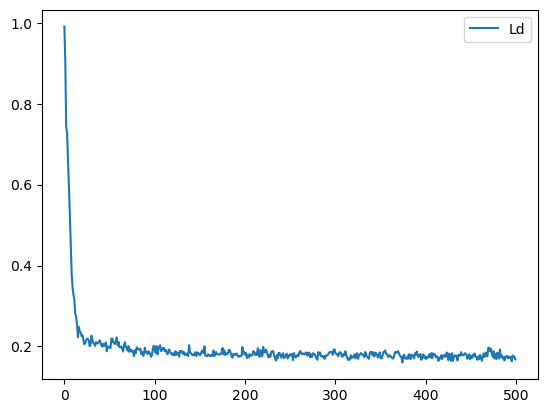

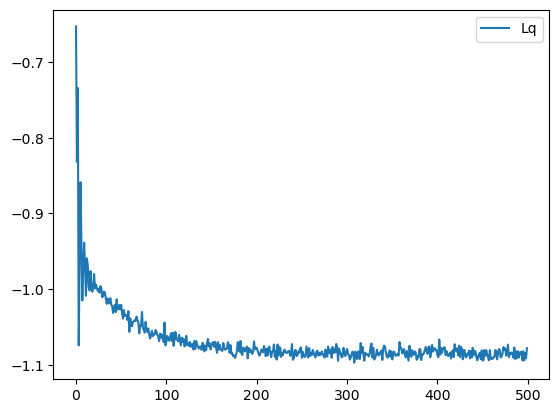

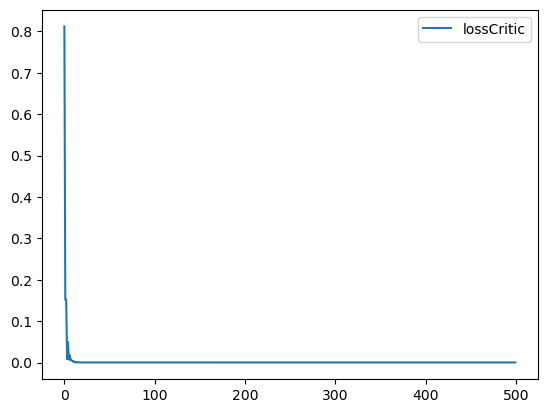

In [ ]:
def smooth(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

obv_idxs = -500
window_size = 1
plt.plot(smooth(info['LdRecord'][obv_idxs:], window_size=window_size), label="Ld")
plt.legend()
plt.show()
plt.plot(smooth(info['LqRecord'][obv_idxs:], window_size=window_size), label="Lq")
plt.legend()
plt.show()
plt.plot(smooth(info['lossCriticRecord'][obv_idxs:], window_size=window_size), label="lossCritic")
plt.legend()
plt.show()